This code is licensed under the MIT License. You may obtain a copy
of the License at https://opensource.org/licenses/MIT.

In [ ]:
!pip install pykrx

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 333, in run
    build_tracker = self.enter_context(get_build_tracker())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/command_context.py", line 27, in enter_context
    return self._main_context.enter_context(context_provider)
  File "/usr/lib/python3.10/contextlib.py", line 492, in enter_context
    result = _cm_type.__enter__(cm)
  File "/usr/lib/python3.10/contextlib.py", line 135, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/build/build_tracker.py", line 45, in get_build_tracker
    root = ctx.

In [ ]:
from pykrx import stock
from pykrx import bond
df = stock.get_market_cap("20240913")
top200_df = df.nlargest(200, '시가총액').sort_index()
top200_df.index

Index(['000080', '000100', '000120', '000150', '000240', '000250', '000270',
       '000660', '000720', '000810',
       ...
       '377300', '383220', '395400', '402340', '403870', '443060', '450080',
       '454910', '457190', '462870'],
      dtype='object', name='티커', length=200)

In [ ]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

tickers = top200_df.index

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. CNN-LSTM MODEL

In [ ]:
import torch
import torch.nn as nn

# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, feature_size, sequence_length)으로 변환
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, conv_output_size)으로 변환
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

In [ ]:
conv1_channels = 32
conv2_channels = 64
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.3

cnn_lstm_model = CNN_LSTM(input_size=X_train_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                          output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                          kernel_size=kernel_size, dropout=dropout)

# 손실 함수 및 adam opt
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN + LSTM 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

num_epochs = 50
trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)

Epoch [10/50], Loss: 0.000263
Epoch [20/50], Loss: 0.000168
Epoch [30/50], Loss: 0.000120
Epoch [40/50], Loss: 0.000103
Epoch [50/50], Loss: 0.000041


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 모델 평가 지표: RMSE, MSE, MAE
def evaluate_model_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

y_pred = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

evaluate_model_performance(y_test_actual, y_pred)

MSE: 0.0006574030267074704
MAE: 0.019533753395080566
RMSE: 0.025639871135354042


(0.000657403, 0.019533753, 0.025639871)

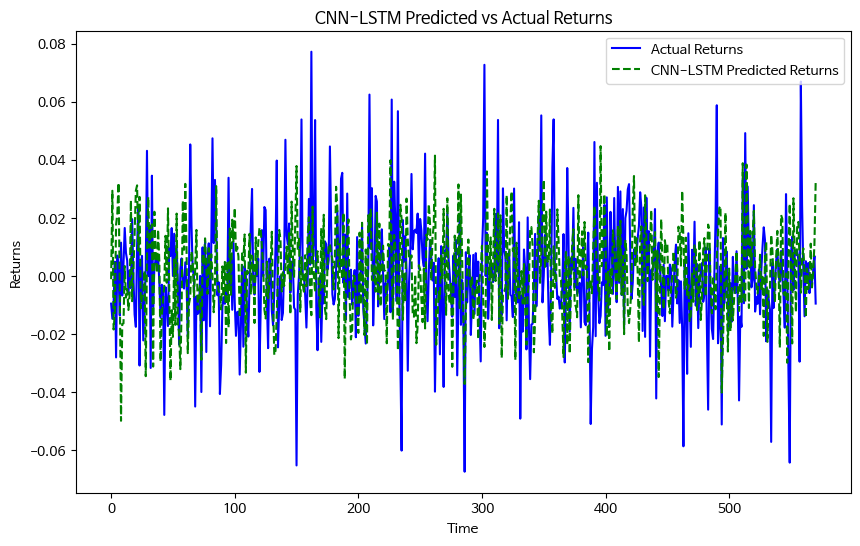

In [ ]:
import matplotlib.pyplot as plt

y_pred_cnn_lstm = trained_cnn_lstm_model(X_test_seq).detach().numpy()  # CNN-LSTM 예측된 수익률
y_test_actual = y_test_seq.numpy()  # 실제 수익률

plt.figure(figsize=(10, 6))

plt.plot(y_test_actual, label='Actual Returns', color='blue')

plt.plot(y_pred_cnn_lstm, label='CNN-LSTM Predicted Returns', color='green', linestyle='--')

plt.title('CNN-LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

plt.show()

In [ ]:
import random
import torch.optim as optim

param_grid = {
    'conv1_channels': [16, 32, 64],
    'conv2_channels': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'dropout': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'epochs': [20, 50]
}

# CNN-LSTM 모델 학습 함수
def train_cnn_lstm_model(params, X_train, y_train, X_test, y_test):

    conv1_channels = params['conv1_channels']
    conv2_channels = params['conv2_channels']
    kernel_size = params['kernel_size']
    dropout = params['dropout']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    cnn_lstm_model = CNN_LSTM(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                              output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                              kernel_size=kernel_size, dropout=dropout)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 모델 학습
    cnn_lstm_model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = cnn_lstm_model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

    cnn_lstm_model.eval()
    with torch.no_grad():
        y_test_pred = cnn_lstm_model(X_test)
        val_loss = criterion(y_test_pred.squeeze(), y_test)

    return val_loss.item()

# Random search로 CNN-LSTM 하이퍼파라미터 튜닝
def random_search_cnn_lstm(param_grid, X_train, y_train, X_test, y_test, n_iter=10):
    best_loss = float('inf')
    best_params = None

    for i in range(n_iter):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        print(f"\nRunning model with params: {params}")

        val_loss = train_cnn_lstm_model(params, X_train, y_train, X_test, y_test)

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            print(f"New best model found with loss: {best_loss}")

    return best_params, best_loss

best_params, best_loss = random_search_cnn_lstm(param_grid, X_train_seq, y_train_seq, X_test_seq, y_test_seq, n_iter=10)

print(f"Best Parameters: {best_params}, Best Loss: {best_loss}")


Running model with params: {'conv1_channels': 64, 'conv2_channels': 32, 'kernel_size': 2, 'dropout': 0.5, 'learning_rate': 0.005, 'batch_size': 64, 'epochs': 20}
Epoch [10/20], Loss: 0.000294
Epoch [20/20], Loss: 0.000298
New best model found with loss: 0.000440095056546852

Running model with params: {'conv1_channels': 64, 'conv2_channels': 32, 'kernel_size': 4, 'dropout': 0.5, 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 50}
Epoch [10/50], Loss: 0.000381
Epoch [20/50], Loss: 0.000243
Epoch [30/50], Loss: 0.000494
Epoch [40/50], Loss: 0.000427
Epoch [50/50], Loss: 0.000449
New best model found with loss: 0.00039492614450864494

Running model with params: {'conv1_channels': 32, 'conv2_channels': 64, 'kernel_size': 4, 'dropout': 0.3, 'learning_rate': 0.005, 'batch_size': 32, 'epochs': 50}
Epoch [10/50], Loss: 0.000165
Epoch [20/50], Loss: 0.000162
Epoch [30/50], Loss: 0.000250
Epoch [40/50], Loss: 0.000102
Epoch [50/50], Loss: 0.000093

Running model with params: {'conv1_channe

- Best Parameter

In [ ]:
# 최적의 하이퍼파라미터 대입
conv1_channels = 32
conv2_channels = 32
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.01
batch_size = 64
num_epochs = 20

# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, feature_size) -> (batch_size, feature_size, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # (batch_size, conv_output_size, sequence_length) -> (batch_size, sequence_length, conv_output_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

cnn_lstm_model = CNN_LSTM(input_size=X_train_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                           output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                           kernel_size=kernel_size, dropout=dropout)

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train_seq, y_train_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def train_cnn_lstm_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)

Epoch [10/20], Loss: 0.000311
Epoch [20/20], Loss: 0.000346


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 모델 평가 지표: RMSE, MSE, MAE
def evaluate_model_performance(y_true, y_pred):
    # MSE, MAE, RMSE
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

y_pred = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

evaluate_model_performance(y_test_seq.numpy(), y_pred)

MSE: 0.00041452268487773836
MAE: 0.014807515777647495
RMSE: 0.020359830930829048


(0.00041452268, 0.014807516, 0.02035983)

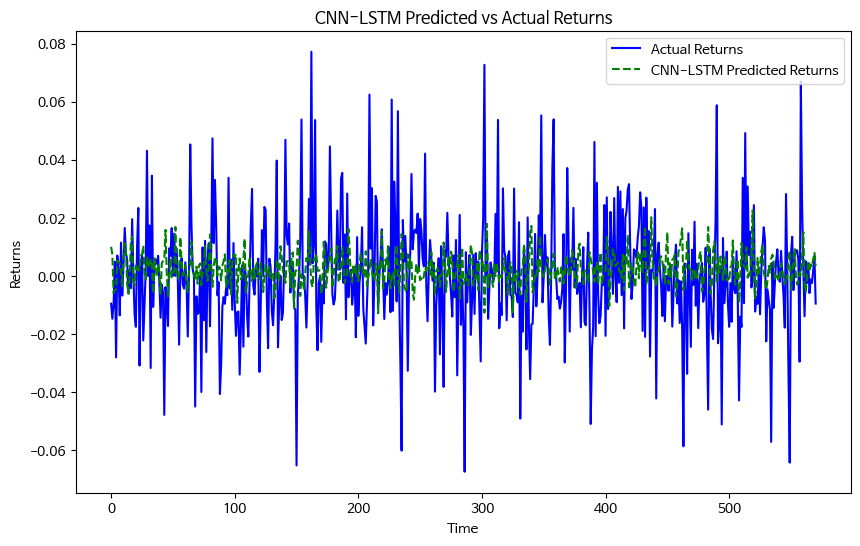

In [ ]:
import matplotlib.pyplot as plt

y_pred_cnn_lstm = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()  # 실제 수익률

plt.figure(figsize=(10, 6))

plt.plot(y_test_actual, label='Actual Returns', color='blue')

# CNN-LSTM 모델 예측 수익률
plt.plot(y_pred_cnn_lstm, label='CNN-LSTM Predicted Returns', color='green', linestyle='--')

plt.title('CNN-LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

plt.show()

## 3. Feature Importances

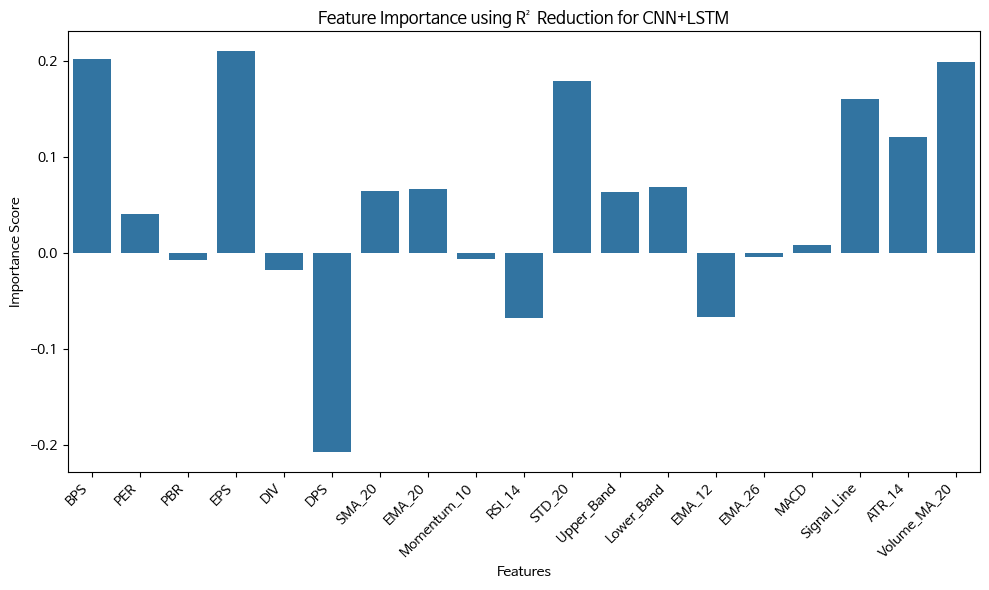

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_r2_feature_importance(model, X_test, y_test, feature_names):
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        # 원본 데이터를 이용해 R² 계산
        y_pred = model(X_test).squeeze(1).detach().numpy()
        baseline_r2 = r2_score(y_test.numpy(), y_pred)

    feature_importances = []

    for i in range(X_test.shape[2]):
        X_test_zeroed = X_test.clone()
        X_test_zeroed[:, :, i] = 0


        with torch.no_grad():
            y_pred_zeroed = model(X_test_zeroed).squeeze(1).detach().numpy()

        reduced_r2 = r2_score(y_test.numpy(), y_pred_zeroed)
        importance = baseline_r2 - reduced_r2  # 중요도는 R² 감소량
        feature_importances.append(importance)

    # 중요도 값을 표준화 (합이 1이 되도록)
    feature_importances = np.array(feature_importances)
    feature_importances /= np.sum(feature_importances)

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=feature_importances)
    plt.title('Feature Importance using R² Reduction for CNN+LSTM')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_importances

importance_scores = calculate_r2_feature_importance(cnn_lstm_model, X_test_seq, y_test_seq, feature_names)

Feature Importance Scores:
BPS: 0.2015
PER: 0.0398
PBR: -0.0081
EPS: 0.2099
DIV: -0.0176
DPS: -0.2073
SMA_20: 0.0643
EMA_20: 0.0665
Momentum_10: -0.0068
RSI_14: -0.0680
STD_20: 0.1792
Upper_Band: 0.0629
Lower_Band: 0.0688
EMA_12: -0.0674
EMA_26: -0.0045
MACD: 0.0076
Signal_Line: 0.1601
ATR_14: 0.1210
Volume_MA_20: 0.1983


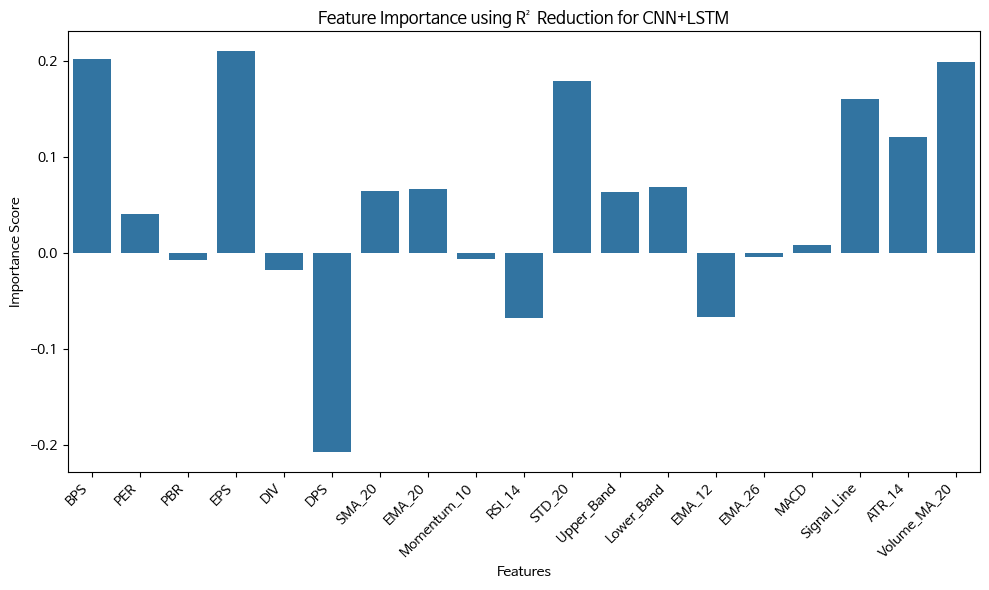

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_r2_feature_importance(model, X_test, y_test, feature_names):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze(1).detach().numpy()  # 모델 예측
        baseline_r2 = r2_score(y_test.numpy(), y_pred)  # 기본 R²

    feature_importances = []

    for i in range(X_test.shape[2]):
        X_test_zeroed = X_test.clone()
        X_test_zeroed[:, :, i] = 0

        with torch.no_grad():
            y_pred_zeroed = model(X_test_zeroed).squeeze(1).detach().numpy()

        reduced_r2 = r2_score(y_test.numpy(), y_pred_zeroed)
        importance = baseline_r2 - reduced_r2
        feature_importances.append(importance)

    # 중요도 값을 표준화 (합이 1이 되도록)
    feature_importances = np.array(feature_importances)
    feature_importances /= np.sum(feature_importances)

    # 변수 중요도 출력
    print("Feature Importance Scores:")
    for feature_name, importance_score in zip(feature_names, feature_importances):
        print(f"{feature_name}: {importance_score:.4f}")

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=feature_importances)
    plt.title('Feature Importance using R² Reduction for CNN+LSTM')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_importances

importance_scores = calculate_r2_feature_importance(cnn_lstm_model, X_test_seq, y_test_seq, feature_names)

## **포트폴리오 구성**

## 평균 predict

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 수익률 계산 함수
def compute_returns(df):
    df['Close'] = df['Close'].ffill()  # 결측치를 이전 값으로 채움
    df['Return'] = df['Close'].pct_change()  # 수익률 계산
    df.dropna(inplace=True)  # NaN 값 제거
    return df

# 데이터 불러오기 및 전처리 함수
def load_and_preprocess_data(ticker):
    file_path = f'/content/drive/My Drive/ticker_data/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])
    target = df['Return']

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 학습 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    # 텐서로 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, features.columns.tolist()

# 예시 티커 데이터를 사용하여 데이터 로드 및 전처리
ticker = '000080'  # 예시 티커
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, feature_names = load_and_preprocess_data(ticker)

if X_train_tensor is None:
    print("데이터가 없거나 처리할 수 없습니다.")
else:
    print("X_train_tensor shape:", X_train_tensor.shape)
    print("y_train_tensor shape:", y_train_tensor.shape)
    print("Feature names:", feature_names)

X_train_tensor shape: torch.Size([2363, 19])
y_train_tensor shape: torch.Size([2363])
Feature names: ['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', 'SMA_20', 'EMA_20', 'Momentum_10', 'RSI_14', 'STD_20', 'Upper_Band', 'Lower_Band', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'ATR_14', 'Volume_MA_20']


In [ ]:
def create_sequences(input_data, target_data, seq_length):
    sequences = []
    targets = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    for i in range(len(input_data) - seq_length):
        sequences.append(input_data[i:i+seq_length])
        targets.append(target_data[i+seq_length])

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

seq_length = 20  # 시퀀스 길이 설정
X_train_seq, y_train_seq = create_sequences(X_train_tensor, y_train_tensor, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_tensor, y_test_tensor, seq_length)

In [ ]:
import torch.nn as nn

# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, feature_size) -> (batch_size, feature_size, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # (batch_size, conv_output_size, sequence_length) -> (batch_size, sequence_length, conv_output_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

# 최적의 하이퍼파라미터 대입
conv1_channels = 64
conv2_channels = 64
kernel_size = 2
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.2
learning_rate = 0.01
batch_size = 64
num_epochs = 20

# 모델 초기화
cnn_lstm_model = CNN_LSTM(input_size=X_train_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                           output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                           kernel_size=kernel_size, dropout=dropout)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

# DataLoader 설정
train_dataset = TensorDataset(X_train_seq, y_train_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN + LSTM 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

# CNN + LSTM 모델 학습
trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)

Epoch [10/20], Loss: 0.000570
Epoch [20/20], Loss: 0.000342


In [ ]:
# 모델 성능 평가 함수
def evaluate_model_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    sharpe_ratio = np.mean(y_pred) / np.std(y_pred)  # 샤프 비율
    max_drawdown = np.min((np.cumprod(1 + y_pred) - 1) / np.maximum.accumulate(np.cumprod(1 + y_pred) - 1))  # 최대 손실

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    print(f"Maximum Drawdown: {max_drawdown}")

# 모델 예측
y_pred = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

# 모델 평가
evaluate_model_performance(y_test_actual, y_pred)

RMSE: 0.020453358069062233
MAE: 0.014805558137595654
MSE: 0.00041833988507278264
R²: -0.08467794811729057
Sharpe Ratio: 0.2046138048171997
Maximum Drawdown: -0.013113196939229965


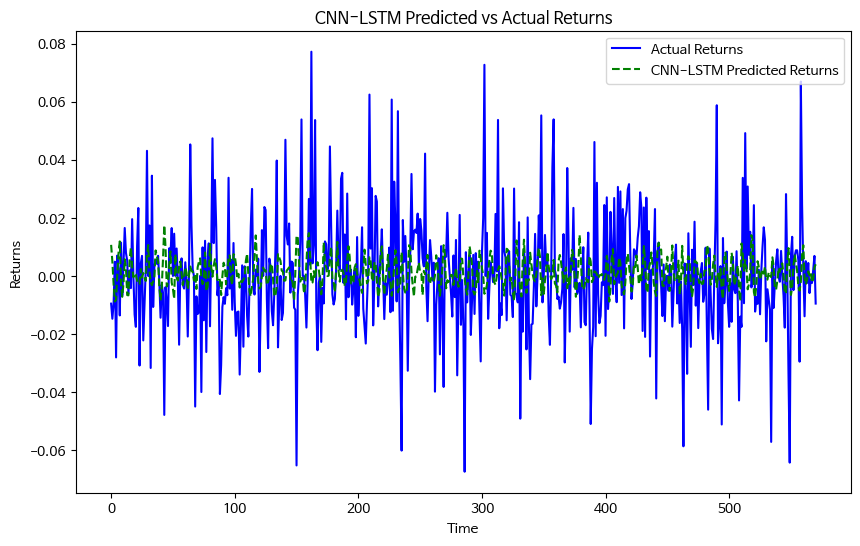

In [ ]:
import matplotlib.pyplot as plt

y_pred_cnn_lstm = trained_cnn_lstm_model(X_test_seq).detach().numpy()  # CNN-LSTM 예측된 수익률
y_test_actual = y_test_seq.numpy()  # 실제 수익률

# 예측 값과 실제 값 시각화
plt.figure(figsize=(10, 6))

# 실제 수익률
plt.plot(y_test_actual, label='Actual Returns', color='blue')

# CNN-LSTM 모델 예측 수익률
plt.plot(y_pred_cnn_lstm, label='CNN-LSTM Predicted Returns', color='green', linestyle='--')

# 그래프 세부 설정
plt.title('CNN-LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# 그래프 출력
plt.show()



---



**- 배열 길이 문제 수정**

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 수익률을 계산하는 함수
def compute_returns(df):
    df['Close'] = df['Close'].ffill()  # 결측치를 이전 값으로 채움
    df['Return'] = df['Close'].pct_change()  # 수익률 계산
    df.dropna(inplace=True)  # NaN 값 제거
    return df

# 데이터 불러오기 및 전처리 함수
def load_and_preprocess_data(ticker):
    file_path = f'/content/drive/My Drive/ticker_data/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])  # 피처만 남기기
    target = df['Return']  # 수익률을 타깃으로 설정

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 학습 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    # 텐서로 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, features.columns.tolist()

In [ ]:
# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, feature_size) -> (batch_size, feature_size, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # (batch_size, conv_output_size, sequence_length) -> (batch_size, sequence_length, conv_output_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

In [ ]:
# 모델 초기화 및 학습 함수 정의
def initialize_and_train_model(X_train_seq, y_train_seq, input_size):
    conv1_channels = 64
    conv2_channels = 64
    kernel_size = 2
    hidden_size = 128
    num_layers = 2
    output_size = 1
    dropout = 0.2
    learning_rate = 0.01
    batch_size = 64
    num_epochs = 20

    # 모델 초기화
    cnn_lstm_model = CNN_LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                               output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                               kernel_size=kernel_size, dropout=dropout)

    # 손실 함수 및 옵티마이저 정의
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

    # DataLoader 설정
    train_dataset = TensorDataset(X_train_seq, y_train_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # CNN + LSTM 모델 학습 함수
    def train_cnn_lstm_model(model, train_loader, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)
                loss.backward()
                optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
        return model

    # CNN + LSTM 모델 학습
    trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)
    return trained_cnn_lstm_model

In [ ]:
# 예측 수익률 및 실제 수익률을 티커별로 저장하는 함수 (날짜 처리 수정)
def add_predicted_returns_to_file(ticker, model, seq_length=20):
    # 데이터 로드 및 전처리
    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, feature_names = load_and_preprocess_data(ticker)
    if X_train_tensor is None:
        print(f"{ticker} 데이터를 처리할 수 없습니다.")
        return

    # 시퀀스 데이터 생성
    def create_sequences(input_data, target_data, seq_length):
        sequences = []
        targets = []

        input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
        target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

        for i in range(len(input_data) - seq_length):
            sequences.append(input_data[i:i+seq_length])
            targets.append(target_data[i+seq_length])

        return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    X_test_seq, y_test_seq = create_sequences(X_test_tensor, y_test_tensor, seq_length)

    # 예측 수익률 계산
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_seq).squeeze().numpy()

    original_df = pd.read_csv(f'/content/drive/My Drive/ticker_data/{ticker}_features.csv', index_col=0)
    date_index = pd.to_datetime(original_df.index[-len(y_pred):])

    result_df = pd.DataFrame({
        'Date': date_index,
        'Predicted_Return': y_pred,
        'Actual_Return': y_test_seq.numpy()
    })


    result_file_path = f'/content/drive/My Drive/ticker_data/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장했습니다.")

In [ ]:
# 함수 테스트 예시 000080
ticker = '000080'
input_size = X_train_tensor.shape[1]
trained_model = initialize_and_train_model(X_train_seq, y_train_seq, input_size)
add_predicted_returns_to_file(ticker, trained_model, seq_length=20)

Epoch [10/20], Loss: 0.000564
Epoch [20/20], Loss: 0.000281
000080의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data/000080_predicted_returns.csv에 저장했습니다.


In [ ]:
top200_df.index

Index(['000080', '000100', '000120', '000150', '000240', '000250', '000270',
       '000660', '000720', '000810',
       ...
       '377300', '383220', '395400', '402340', '403870', '443060', '450080',
       '454910', '457190', '462870'],
      dtype='object', name='티커', length=200)

- 데이터 업데이트 필요

In [ ]:
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import time

# CNN-LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

# 시퀀스 생성 함수 (2020년 이후의 데이터 사용)
def create_sequences_for_all_dates(input_data, target_data, date_index, seq_length):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대해 시퀀스 생성
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(i)  # 날짜 인덱스 저장

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates # 모든 피처 사용을 위한 데이터 로드 및 전처리 함수 (2020년 이후의 데이터만 사용)
def load_and_preprocess_data_with_all_features(ticker):
    file_path = f'/content/drive/My Drive/ticker_data_1/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    # 2020년 이후의 데이터만 필터링
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= '2020-01-01']

    # 수익률 계산 및 모든 피처 사용
    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])  # 모든 피처 사용
    target = df['Return']  # 수익률을 타깃으로 설정

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 텐서로 변환
    X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(target.values, dtype=torch.float32)

    return X_tensor, y_tensor, features.columns.tolist(), df.index # 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs, criterion, optimizer, checkpoint_interval, checkpoint_dir, ticker):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        # 지정한 간격으로 체크포인트 저장
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'{ticker}_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f} - Checkpoint saved to {checkpoint_path}")
    return model

# 예측 수익률을 저장하는 함수
def add_predicted_returns_to_file(ticker, model, seq_length=20):
    X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
    if X_tensor is None:
        print(f"{ticker} 데이터 처리 불가능")
        return

    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length)

    # 예측 수익률 계산
    model.eval()
    with torch.no_grad():
        y_pred = model(X_seq).squeeze().numpy()

    pred_dates = date_index[dates]

    # 예측 수익률과 실제 수익률을 데이터프레임으로 저장
    result_df = pd.DataFrame({
        'Date': pred_dates,
        'Predicted_Return': y_pred,
        'Actual_Return': y_seq.numpy()
    })

    # 데이터 저장
    result_file_path = f'/content/drive/My Drive/ticker_data_1/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장함.") # 모든 티커에 대해 모델 학습 및 저장 수행
def train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, seq_length=20):

    conv1_channels, conv2_channels, kernel_size, hidden_size, num_layers, output_size, dropout, learning_rate, batch_size = model_params

    # 손실 함수 & 옵티마이저
    criterion = nn.MSELoss()

    for idx, ticker in enumerate(tickers_list):
        X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
        if X_tensor is None:
            print(f"Ticker {ticker}: 데이터 로드 실패")
            continue

        cnn_lstm_model = CNN_LSTM(input_size=len(feature_names), hidden_size=hidden_size, num_layers=num_layers,
                                  output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                                  kernel_size=kernel_size, dropout=dropout)
        optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

        X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length)

        train_dataset = TensorDataset(X_seq, y_seq)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # 모델 학습 및 저장
        print(f"Ticker {ticker} ({idx + 1}/{len(tickers_list)}) 모델 학습 processing")
        start_time = time.time()
        trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer,
                                             checkpoint_interval, checkpoint_dir, ticker)
        print(f"Ticker {ticker} 학습 완료 - 학습 시간: {time.time() - start_time:.2f} 초")

        # 예측 수익률을 파일에 저장
        add_predicted_returns_to_file(ticker, trained_model, seq_length)

model_params = (32, 32, 3, 128, 2, 1, 0.5, 0.01, 64)
num_epochs = 20
checkpoint_interval = 5  # 5 에포크마다 모델 저장
checkpoint_dir = '/content/drive/My Drive/ticker_checkpoints_2/'  # 체크포인트 저장 경로
os.makedirs(checkpoint_dir, exist_ok=True)


tickers_list = top200_df.index

# 모든 티커에 대해 모델 학습 및 저장 수행
train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir)

## **모든 티커들 값에 대해 실행**
### 최종 코드 및 백테스트

In [ ]:
top200_df.index

Index(['000080', '000100', '000120', '000150', '000240', '000250', '000270',
       '000660', '000720', '000810',
       ...
       '377300', '383220', '395400', '402340', '403870', '443060', '450080',
       '454910', '457190', '462870'],
      dtype='object', name='티커', length=200)

In [ ]:
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import time

folder_path = '/content/drive/My Drive/ticker_data_2/'

# 폴더가 존재하지 않으면 생성
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"폴더 생성: {folder_path}")
else:
    print(f"폴더 이미 존재: {folder_path}")


# CNN-LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

# 시퀀스 생성 함수 (6개월 후의 수익률 예측)
def create_sequences_for_all_dates(input_data, target_data, date_index, seq_length, prediction_gap=120):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    for i in range(seq_length, len(input_data) - prediction_gap):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i + prediction_gap - 1])  # prediction_gap 달 후의 수익률
        dates.append(i + prediction_gap - 1)

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

# 데이터 전처리
def load_and_preprocess_data_with_all_features(ticker):
    file_path = f'/content/drive/My Drive/ticker_data_1/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    # 2020년 이후의 데이터만 필터링
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= '2020-01-01']

    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])
    target = df['Return']  # 수익률을 타깃으로 설정

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 텐서로 변환
    X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(target.values, dtype=torch.float32)

    return X_tensor, y_tensor, features.columns.tolist(), df.index

# 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs, criterion, optimizer, checkpoint_interval, checkpoint_dir, ticker):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'{ticker}_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f} - Checkpoint saved to {checkpoint_path}")
    return model

def add_predicted_returns_to_file(ticker, model, seq_length=20, prediction_gap=120):
    X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
    if X_tensor is None:
        print(f"{ticker} 데이터 처리 불가능")
        return

    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length, prediction_gap)

    # 예측 수익률 계산
    model.eval()
    with torch.no_grad():
        y_pred = model(X_seq).squeeze().numpy()

    pred_dates = date_index[dates]

    # 예측 수익률과 실제 수익률을 데이터프레임으로 저장
    result_df = pd.DataFrame({
        'Date': pred_dates,
        'Predicted_Return': y_pred,
        'Actual_Return': y_seq.numpy()
    })

    # 데이터 저장
    result_file_path = f'/content/drive/My Drive/ticker_data_2/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장함.")

# 모든 티커에 대해 모델 학습 및 저장 수행
def train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, seq_length=20, prediction_gap=120):

    conv1_channels, conv2_channels, kernel_size, hidden_size, num_layers, output_size, dropout, learning_rate, batch_size = model_params

    # 손실 함수(MSE) & 옵티마이저(Adam)
    criterion = nn.MSELoss()

    for idx, ticker in enumerate(tickers_list):
        X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
        if X_tensor is None:
            print(f"Ticker {ticker}: 데이터 로드 실패")
            continue

        cnn_lstm_model = CNN_LSTM(input_size=len(feature_names), hidden_size=hidden_size, num_layers=num_layers,
                                  output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                                  kernel_size=kernel_size, dropout=dropout)
        optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

        X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length, prediction_gap)

        train_dataset = TensorDataset(X_seq, y_seq)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        print(f"Ticker {ticker} ({idx + 1}/{len(tickers_list)}) 모델 학습 processing")
        start_time = time.time()
        trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer,
                                             checkpoint_interval, checkpoint_dir, ticker)
        print(f"Ticker {ticker} 학습 완료 - 학습 시간: {time.time() - start_time:.2f} 초")

        # 예측 수익률을 파일에 저장
        add_predicted_returns_to_file(ticker, trained_model, seq_length, prediction_gap)


model_params = (32, 32, 3, 128, 2, 1, 0.5, 0.01, 64)
num_epochs = 20
checkpoint_interval = 5  # 5 에포크마다 모델 저장
checkpoint_dir = '/content/drive/My Drive/ticker_checkpoints_2/'
os.makedirs(checkpoint_dir, exist_ok=True)

tickers_list = top200_df.index

# 모든 티커에 대해 모델 학습 및 저장 수행
train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, seq_length=20, prediction_gap=120)

폴더가 생성됨: /content/drive/My Drive/ticker_data_2/
Ticker 000080 (1/200) 모델 학습 processing
Epoch [5/20], Loss: 0.000259 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_5.pt
Epoch [10/20], Loss: 0.000257 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_10.pt
Epoch [15/20], Loss: 0.000215 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_15.pt
Epoch [20/20], Loss: 0.000276 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_20.pt
Ticker 000080 학습 완료 - 학습 시간: 5.57 초
000080의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2/000080_predicted_returns.csv에 저장함.
Ticker 000100 (2/200) 모델 학습 processing
Epoch [5/20], Loss: 0.000586 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000100_epoch_5.pt
Epoch [10/20], Loss: 0.000371 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000100_epoch_10.pt
Epoch [15/20], Loss: 0.000487 - Checkpoint saved to 

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# num_samples Value Error 발생 시

def get_tickers_without_results(result_dir, tickers_list):
    tickers_without_results = []
    for ticker in tickers_list:
        result_file_path = f'{result_dir}/{ticker}_predicted_returns.csv'
        if not os.path.exists(result_file_path):
            tickers_without_results.append(ticker)
    return tickers_without_results


def train_and_save_model_for_tickers_without_results(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, result_dir, seq_length=20, prediction_gap=120):
    # 예측 결과가 없는 티커만 필터링
    tickers_list = get_tickers_without_results(result_dir, tickers_list)

    print(f"예측 결과가 없는 티커 수: {len(tickers_list)}")
    if len(tickers_list) == 0:
        print("모든 티커의 예측 결과가 이미 존재함.")
        return

    conv1_channels, conv2_channels, kernel_size, hidden_size, num_layers, output_size, dropout, learning_rate, batch_size = model_params
    criterion = nn.MSELoss()

    for idx, ticker in enumerate(tickers_list):
        X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
        if X_tensor is None:
            print(f"Ticker {ticker}: 데이터 로드 실패")
            continue

        X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length, prediction_gap)

        # 데이터의 크기 검증 및 건너뛰기
        if len(X_seq) == 0 or len(y_seq) == 0:
            print(f"Ticker {ticker}: 시퀀스 생성 실패 - 데이터가 부족합니다. 이 티커를 건너뜁니다.")
            continue

        train_dataset = TensorDataset(X_seq, y_seq)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # 모델 초기화
        cnn_lstm_model = CNN_LSTM(input_size=len(feature_names), hidden_size=hidden_size, num_layers=num_layers,
                                  output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                                  kernel_size=kernel_size, dropout=dropout)
        optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

        print(f"Ticker {ticker} ({idx + 1}/{len(tickers_list)}) 모델 학습 시작")
        start_time = time.time()
        trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer,
                                             checkpoint_interval, checkpoint_dir, ticker)
        print(f"Ticker {ticker} 학습 완료 - 학습 시간: {time.time() - start_time:.2f} 초")

        # 예측 수익률을 파일에 저장
        add_predicted_returns_to_file(ticker, trained_model, seq_length, prediction_gap)

model_params = (32, 32, 3, 128, 2, 1, 0.5, 0.01, 64)
num_epochs = 20
checkpoint_interval = 5
checkpoint_dir = '/content/drive/My Drive/ticker_checkpoints_2/'
result_dir = '/content/drive/My Drive/ticker_data_2/'

# 예측 결과가 없는 티커들에 대해 학습 시작
train_and_save_model_for_tickers_without_results(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, result_dir, seq_length=20, prediction_gap=120)


예측 결과가 없는 티커 수: 28
Ticker 278470: 시퀀스 생성 실패 - 데이터가 부족합니다. 이 티커를 건너뜁니다.
Ticker 282330 (2/28) 모델 학습 시작
Epoch [5/20], Loss: 0.000377 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/282330_epoch_5.pt
Epoch [10/20], Loss: 0.000340 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/282330_epoch_10.pt
Epoch [15/20], Loss: 0.000375 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/282330_epoch_15.pt
Epoch [20/20], Loss: 0.000402 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/282330_epoch_20.pt
Ticker 282330 학습 완료 - 학습 시간: 6.41 초
282330의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2/282330_predicted_returns.csv에 저장함.
Ticker 293490 (3/28) 모델 학습 시작


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [5/20], Loss: 0.000033 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/293490_epoch_5.pt
Epoch [10/20], Loss: 0.000020 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/293490_epoch_10.pt
Epoch [15/20], Loss: 0.000002 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/293490_epoch_15.pt
Epoch [20/20], Loss: 0.000972 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/293490_epoch_20.pt
Ticker 293490 학습 완료 - 학습 시간: 5.33 초
293490의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2/293490_predicted_returns.csv에 저장함.
Ticker 294870 (4/28) 모델 학습 시작
Epoch [5/20], Loss: 0.000707 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/294870_epoch_5.pt
Epoch [10/20], Loss: 0.000720 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/294870_epoch_10.pt
Epoch [15/20], Loss: 0.000444 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/294870_epoch_15.pt
Epoch [20/20], Loss: 0.000615 - 

In [ ]:
import os

# 모든 티커의 데이터를 로드하여 2023년 12월 28일 데이터 필터링
def load_and_filter_data(tickers_list, checkpoint_dir, target_date='2023-12-28'):
    combined_data = pd.DataFrame()
    target_date = pd.to_datetime(target_date)

    for ticker in tickers_list:
        file_path = f'{checkpoint_dir}/{ticker}_predicted_returns.csv'
        try:
            data = pd.read_csv(file_path, index_col=0)
            data.index = pd.to_datetime(data.index)
            # target_date의 데이터만 필터링
            data = data[data.index == target_date]
            if not data.empty:
                data['Date'] = data.index
                data['Ticker'] = ticker
                combined_data = pd.concat([combined_data, data], ignore_index=True)
        except FileNotFoundError:
            print(f"{ticker} File Error : {file_path} ")
        except Exception as e:
            print(f"{ticker} Data Loading Error : {e}")

    return combined_data

def get_top_10_tickers_on_date(data):
    if data.empty:
        print("Data Nan")
        return []


    top_10_tickers = data.nlargest(10, 'Predicted_Return')['Ticker'].tolist()
    return top_10_tickers

tickers_list = top200_df.index
checkpoint_dir = '/content/drive/MyDrive/ticker_data_2'

data = load_and_filter_data(tickers_list, checkpoint_dir, target_date='2023-12-28')

real_top10_tickers = get_top_10_tickers_on_date(data)
print("예측 수익률 상위 10개 티커:", top_10_tickers_on_date)

278470 파일이 /content/drive/MyDrive/ticker_data_2/278470_predicted_returns.csv 없습니다.
443060 파일이 /content/drive/MyDrive/ticker_data_2/443060_predicted_returns.csv 없습니다.
462870 파일이 /content/drive/MyDrive/ticker_data_2/462870_predicted_returns.csv 없습니다.
2023년 12월 29일 예측 수익률 상위 10개 티커: ['348370', '310210', '009420', '196170', '241560', '000250', '010620', '003090', '020150', '257720']


In [ ]:
# MDD 계산 함수
def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# 포트폴리오 누적 수익률, MDD 계산 및 시각화 함수
def visualize_portfolio_performance(tickers, start_date, end_date, investment_ratio=1.0):
    portfolio_returns = pd.DataFrame()

    for ticker in tickers:
        ticker_data = get_ticker_cumulative_returns(ticker, start_date, end_date)
        portfolio_returns[ticker] = ticker_data['Returns']

    # 티커별 동일한 비율로 투자했다고 가정 (기본적으로 동일 가중치)
    portfolio_returns['Portfolio_Return'] = portfolio_returns.mean(axis=1) * investment_ratio

    # 포트폴리오 누적 수익률 계산
    portfolio_returns['Cumulative_Return'] = (1 + portfolio_returns['Portfolio_Return']).cumprod() - 1

    # 최대 낙폭 계산
    max_drawdown = calculate_max_drawdown(portfolio_returns['Portfolio_Return'].dropna())  # 변경된 부분
    cumulative_max_drawdown = calculate_max_drawdown(portfolio_returns['Cumulative_Return'].dropna())  # 누적 수익률 기준 MDD

    portfolio_returns['Drawdown'] = portfolio_returns['Cumulative_Return'] - portfolio_returns['Cumulative_Return'].cummax()

    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=('Cumulative Return', 'Max Drawdown')
    )

    # 누적 수익률 그래프
    fig.add_trace(
        go.Scatter(x=portfolio_returns.index, y=portfolio_returns['Cumulative_Return'],
                   mode='lines', name='Cumulative Return'),
        row=1, col=1
    )

    # 최대 낙폭 그래프
    fig.add_trace(
        go.Scatter(x=portfolio_returns.index, y=portfolio_returns['Drawdown'],
                   mode='lines', name='Max Drawdown'),
        row=2, col=1
    )

    # 레이아웃 설정
    fig.update_layout(
        height=900, width=1000,
        title_text=f"Portfolio Performance ({start_date} ~ {end_date})",
        annotations=[
            dict(
                xref='paper', yref='paper',
                x=1.05, y=1.05,
                showarrow=False,
                text=f"Max Drawdown: {max_drawdown:.4f}<br>Cumulative Max Drawdown: {cumulative_max_drawdown:.4f}",  # 누적 기준 MDD 추가
                font=dict(size=12),
                align='left',
                bordercolor='black',
                borderwidth=1,
                borderpad=4,
                bgcolor='white',
                opacity=0.8
            )
        ]
    )
    fig.update_yaxes(tickformat=".2%")

    fig.show()

    print(f"포트폴리오 최대 낙폭(MDD): {max_drawdown:.4f}")
    print(f"포트폴리오 누적 기준 최대 낙폭(Cumulative MDD): {cumulative_max_drawdown:.4f}")

top_10_tickers = real_top10_tickers
start_date = '2024-01-01'
end_date = '2024-06-01'

visualize_portfolio_performance(top_10_tickers, start_date, end_date)

포트폴리오 최대 낙폭(MDD): -0.1096
포트폴리오 누적 기준 최대 낙폭(Cumulative MDD): -0.7088


In [ ]:
tickers = real_top10_tickers
for ticker in tickers:
    종목 = stock.get_market_ticker_name(ticker)
    print(종목)

엔켐
보로노이
한올바이오파마
알테오젠
두산밥캣
삼천당제약
HD현대미포
대웅
롯데에너지머티리얼즈
실리콘투


In [ ]:
data = []

for ticker in tickers:
    종목명 = stock.get_market_ticker_name(ticker)
    data.append([ticker, 종목명])

df = pd.DataFrame(data, columns=['Ticker', '종목명'])
df

,Ticker,종목명
0,348370,엔켐
1,310210,보로노이
2,009420,한올바이오파마
3,196170,알테오젠
4,241560,두산밥캣
5,000250,삼천당제약
6,010620,HD현대미포
7,003090,대웅
8,020150,롯데에너지머티리얼즈
9,257720,실리콘투


### Screening : 2024년 9월 23일 기준

In [ ]:
# 2024년 9월 23일 기준

def load_and_filter_data(tickers_list, checkpoint_dir, target_date='2024-09-23'):
    combined_data = pd.DataFrame()
    target_date = pd.to_datetime(target_date)

    for ticker in tickers_list:
        file_path = f'{checkpoint_dir}/{ticker}_predicted_returns.csv'
        try:
            data = pd.read_csv(file_path, index_col=0)
            data.index = pd.to_datetime(data.index)

            data = data[data.index == target_date]
            if not data.empty:
                data['Date'] = data.index
                data['Ticker'] = ticker
                combined_data = pd.concat([combined_data, data], ignore_index=True)
        except FileNotFoundError:
            print(f"{ticker} File Error : {file_path}")
        except Exception as e:
            print(f"{ticker} Data Loading Error : {e}")

    return combined_data

def get_top_10_tickers_on_date(data):
    if data.empty:
        print("Data Nan")
        return []

    top_10_tickers = data.nlargest(10, 'Predicted_Return')['Ticker'].tolist()
    return top_10_tickers

tickers_list = top200_df.index
checkpoint_dir = '/content/drive/MyDrive/ticker_data_2'

data = load_and_filter_data(tickers_list, checkpoint_dir, target_date='2024-09-23')

top10_tickers = get_top_10_tickers_on_date(data)
print("예측 수익률 상위 10개 티커:", top_10_tickers_on_date)

278470 파일이 /content/drive/MyDrive/ticker_data_2/278470_predicted_returns.csv 없습니다.
443060 파일이 /content/drive/MyDrive/ticker_data_2/443060_predicted_returns.csv 없습니다.
462870 파일이 /content/drive/MyDrive/ticker_data_2/462870_predicted_returns.csv 없습니다.
해당 날짜의 데이터가 없습니다.
2024년 9월 23일 예측 수익률 상위 10개 티커: ['348370', '310210', '009420', '196170', '241560', '000250', '010620', '003090', '020150', '257720']


In [ ]:
tickers = ['348370', '310210', '009420', '196170', '241560', '000250', '010620', '003090', '020150', '257720']
for ticker in tickers:
    종목 = stock.get_market_ticker_name(ticker)
    print(종목)

엔켐
보로노이
한올바이오파마
알테오젠
두산밥캣
삼천당제약
HD현대미포
대웅
롯데에너지머티리얼즈
실리콘투


In [ ]:
data = []

for ticker in tickers:
    종목명 = stock.get_market_ticker_name(ticker)
    data.append([ticker, 종목명])

df = pd.DataFrame(data, columns=['Ticker', '종목명'])
df

,Ticker,종목명
0,348370,엔켐
1,310210,보로노이
2,009420,한올바이오파마
3,196170,알테오젠
4,241560,두산밥캣
5,000250,삼천당제약
6,010620,HD현대미포
7,003090,대웅
8,020150,롯데에너지머티리얼즈
9,257720,실리콘투


In [ ]:
from pykrx import stock
import pandas as pd

# 투자 금액 및 수수료 설정
initial_investment = 100000000  # 1억원
commission_rate = 0.035

available_investment = initial_investment * (1 - commission_rate)

tickers = ['348370', '310210', '009420', '196170', '241560', '000250', '010620', '003090', '020150', '257720']

shares_to_buy = {}

end_date = "2024-09-23"

for ticker in tickers:
    ohlcv_df = stock.get_market_ohlcv_by_date("20240101", end_date, ticker)

    if not ohlcv_df.empty:
        # 마지막 거래일의 종가 가져오기
        last_close_price = ohlcv_df['종가'].iloc[-1]

        num_shares = available_investment // last_close_price

        shares_to_buy[ticker] = num_shares
    else:
        print(f"Ticker: {ticker}, No data.")

for ticker, shares in shares_to_buy.items():
    print(f"Ticker: {ticker}, 구매수량: {shares:.0f}")

Ticker: 348370, 구매수량: 525
Ticker: 310210, 구매수량: 996
Ticker: 009420, 구매수량: 2496
Ticker: 196170, 구매수량: 275
Ticker: 241560, 구매수량: 2297
Ticker: 000250, 구매수량: 670
Ticker: 010620, 구매수량: 911
Ticker: 003090, 구매수량: 3711
Ticker: 020150, 구매수량: 2391
Ticker: 257720, 구매수량: 2088
